In [102]:
import torch

# Replace 'your_file.pt' with the path to your EEG data file
file_path = r'EEG\train_0.pt'

# Load the file
data = torch.load(file_path, weights_only=False)

# Check the type of the loaded data
print("Data type:", type(data))

# If it's a dictionary, print out its keys and some details about each item
if isinstance(data, dict):
    print("Keys found in the data:")
    for key, value in data.items():
        print(f" - {key} (type: {type(value)})")
        # If the value is a tensor, print its shape
        if hasattr(value, 'shape'):
            print(f"   Shape: {value.shape}")
        else:
            print(f"   Value: {value}")
else:
    # For non-dictionary data, simply print the content
    print("Data content:", data)

Data type: <class 'dict'>
Keys found in the data:
 - samples (type: <class 'numpy.ndarray'>)
   Shape: (1377, 3000, 1)
 - labels (type: <class 'numpy.ndarray'>)
   Shape: (1377,)


Samples shape: (1377, 3000, 1)
Labels shape: (1377,)
First 5 labels: [0 2 2 2 0]


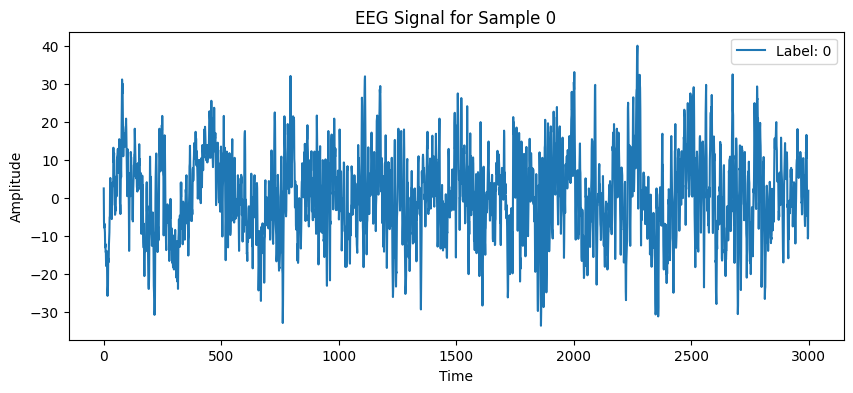

In [103]:
import matplotlib.pyplot as plt
import numpy as np

samples = data['samples']  # shape: (1377, 3000, 1)
labels = data['labels']    # shape: (1377,)

# Print shapes
print("Samples shape:", samples.shape)
print("Labels shape:", labels.shape)

# Optionally, print the first few labels
print("First 5 labels:", labels[:5])

# Visualize the first sample:
# The sample has shape (3000, 1); we squeeze it to (3000,) for plotting.
first_sample = np.squeeze(samples[0])
first_label = labels[0]

plt.figure(figsize=(10, 4))
plt.plot(first_sample, label=f'Label: {first_label}')
plt.title("EEG Signal for Sample 0")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [104]:
import torch
import numpy as np
import os

# Directory where all your .pt files are located
data_dir = r'EEG'

# Load all files
train_samples = []
train_labels = []

for file_name in os.listdir(data_dir):
    if file_name.endswith(".pt") and file_name.startswith("train"):
        file_path = os.path.join(data_dir, file_name)
        data = torch.load(file_path, weights_only=False)
        train_samples.append(data['samples'])
        train_labels.append(data['labels'])

# Convert to numpy arrays
train_samples = np.concatenate(train_samples, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print(f"Train samples shape: {train_samples.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train samples shape: (29606, 3000, 1)
Train labels shape: (29606,)


In [105]:
test_samples = []
test_labels = []

for file_name in os.listdir(data_dir):
    if file_name.endswith(".pt") and file_name.startswith("test"):
        file_path = os.path.join(data_dir, file_name)
        data = torch.load(file_path, weights_only=False)
        test_samples.append(data['samples'])
        test_labels.append(data['labels'])

# Convert to numpy arrays
test_samples = np.concatenate(test_samples, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print(f"Train samples shape: {test_samples.shape}")
print(f"Train labels shape: {test_labels.shape}")

Train samples shape: (12702, 3000, 1)
Train labels shape: (12702,)


In [106]:
import numpy as np
import scipy.signal as signal
import pywt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Bandpass filter using scipy
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data, axis=-1)
    return filtered_data

# Fourier Transform Feature Extraction
def fourier_transform(data):
    # Apply FFT to the data and return the frequency spectrum
    return np.abs(np.fft.fft(data, axis=-1))

# Wavelet Transform Feature Extraction
def wavelet_transform(data, wavelet='cmor'):
    coeffs, _ = pywt.dwt(data, wavelet)
    return coeffs

# Normalization (Standardization)
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

# Custom Dataset for EEG
class EEGDataset(Dataset):
    def __init__(self, samples, labels, transform=None):
        self.samples = samples
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [107]:
# Apply bandpass filter, Fourier Transform, and normalization
train_samples_filtered = bandpass_filter(train_samples)
train_samples_fourier = fourier_transform(train_samples_filtered)
train_samples_normalized = normalize_data(train_samples_fourier)

test_samples_filtered = bandpass_filter(test_samples)
test_samples_fourier = fourier_transform(test_samples_filtered)
test_samples_normalized = normalize_data(test_samples_fourier)

X_train, X_val, y_train, y_val = train_samples_normalized, test_samples_normalized, train_labels, test_labels

# Create datasets and dataloaders
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [108]:
import torch.nn as nn
import torch.optim as optim

# Define CNN model
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 1500, 256)  
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) 
        x = x.reshape(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [109]:
class LSTM(nn.Module):
    def __init__(self, input_size=3000, hidden_size=128, num_classes=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  
        out = self.fc(out)
        return out

In [110]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [111]:
cnn_model = CNN(input_channels=1, num_classes=5)
lstm_model = LSTM(input_size=3000, hidden_size=128, num_classes=5)
cnn_lstm_model = CNN_LSTM(input_channels=1, num_classes=5)

In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader,desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            inputs = inputs.permute(0, 2, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()
                inputs = inputs.permute(0, 2, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda


Epoch 1/25: 100%|██████████| 926/926 [00:20<00:00, 44.92it/s]


Epoch [1/25], Train Loss: 1.5641, Train Accuracy: 43.55%, Val Loss: 1.1985, Val Accuracy: 49.91%


Epoch 2/25: 100%|██████████| 926/926 [00:20<00:00, 44.41it/s]


Epoch [2/25], Train Loss: 1.2548, Train Accuracy: 47.19%, Val Loss: 1.0867, Val Accuracy: 51.62%


Epoch 3/25: 100%|██████████| 926/926 [00:21<00:00, 43.39it/s]


Epoch [3/25], Train Loss: 1.2118, Train Accuracy: 48.59%, Val Loss: 1.1056, Val Accuracy: 52.35%


Epoch 4/25: 100%|██████████| 926/926 [00:20<00:00, 44.61it/s]


Epoch [4/25], Train Loss: 1.1928, Train Accuracy: 49.10%, Val Loss: 1.0072, Val Accuracy: 57.23%


Epoch 5/25: 100%|██████████| 926/926 [00:21<00:00, 43.89it/s]


Epoch [5/25], Train Loss: 1.1695, Train Accuracy: 49.62%, Val Loss: 0.9805, Val Accuracy: 57.02%


Epoch 6/25: 100%|██████████| 926/926 [00:21<00:00, 42.43it/s]


Epoch [6/25], Train Loss: 1.1645, Train Accuracy: 49.51%, Val Loss: 1.0069, Val Accuracy: 55.69%


Epoch 7/25: 100%|██████████| 926/926 [00:23<00:00, 39.31it/s]


Epoch [7/25], Train Loss: 1.1442, Train Accuracy: 49.98%, Val Loss: 0.9474, Val Accuracy: 60.36%


Epoch 8/25: 100%|██████████| 926/926 [00:20<00:00, 44.94it/s]


Epoch [8/25], Train Loss: 1.1381, Train Accuracy: 50.06%, Val Loss: 0.9984, Val Accuracy: 54.44%


Epoch 9/25: 100%|██████████| 926/926 [00:20<00:00, 45.89it/s]


Epoch [9/25], Train Loss: 1.1252, Train Accuracy: 50.25%, Val Loss: 0.9902, Val Accuracy: 57.04%


Epoch 10/25: 100%|██████████| 926/926 [00:20<00:00, 45.55it/s]


Epoch [10/25], Train Loss: 1.1159, Train Accuracy: 50.29%, Val Loss: 0.9420, Val Accuracy: 58.56%


Epoch 11/25: 100%|██████████| 926/926 [00:20<00:00, 44.65it/s]


Epoch [11/25], Train Loss: 1.1087, Train Accuracy: 50.95%, Val Loss: 0.9609, Val Accuracy: 61.86%


Epoch 12/25: 100%|██████████| 926/926 [00:20<00:00, 45.61it/s]


Epoch [12/25], Train Loss: 1.0961, Train Accuracy: 51.21%, Val Loss: 0.9689, Val Accuracy: 59.44%


Epoch 13/25: 100%|██████████| 926/926 [00:20<00:00, 46.17it/s]


Epoch [13/25], Train Loss: 1.0568, Train Accuracy: 53.69%, Val Loss: 0.9516, Val Accuracy: 59.97%


Epoch 14/25: 100%|██████████| 926/926 [00:20<00:00, 45.88it/s]


Epoch [14/25], Train Loss: 1.0320, Train Accuracy: 54.45%, Val Loss: 0.9715, Val Accuracy: 58.65%


Epoch 15/25: 100%|██████████| 926/926 [00:23<00:00, 39.46it/s]


Epoch [15/25], Train Loss: 1.0211, Train Accuracy: 55.76%, Val Loss: 0.9851, Val Accuracy: 58.39%


Epoch 16/25: 100%|██████████| 926/926 [00:19<00:00, 46.60it/s]


Epoch [16/25], Train Loss: 1.0170, Train Accuracy: 56.90%, Val Loss: 0.9365, Val Accuracy: 61.94%


Epoch 17/25: 100%|██████████| 926/926 [00:19<00:00, 46.60it/s]


Epoch [17/25], Train Loss: 1.0001, Train Accuracy: 57.22%, Val Loss: 0.9724, Val Accuracy: 61.13%


Epoch 18/25: 100%|██████████| 926/926 [00:19<00:00, 46.70it/s]


Epoch [18/25], Train Loss: 0.9964, Train Accuracy: 57.20%, Val Loss: 1.0309, Val Accuracy: 59.45%


Epoch 19/25: 100%|██████████| 926/926 [00:20<00:00, 46.24it/s]


Epoch [19/25], Train Loss: 0.9784, Train Accuracy: 58.26%, Val Loss: 0.9870, Val Accuracy: 63.82%


Epoch 20/25: 100%|██████████| 926/926 [00:19<00:00, 46.89it/s]


Epoch [20/25], Train Loss: 0.9562, Train Accuracy: 59.37%, Val Loss: 0.9809, Val Accuracy: 62.69%


Epoch 21/25: 100%|██████████| 926/926 [00:19<00:00, 46.41it/s]


Epoch [21/25], Train Loss: 0.9424, Train Accuracy: 59.59%, Val Loss: 1.0388, Val Accuracy: 64.96%


Epoch 22/25: 100%|██████████| 926/926 [00:19<00:00, 46.57it/s]


Epoch [22/25], Train Loss: 0.9111, Train Accuracy: 60.97%, Val Loss: 1.0251, Val Accuracy: 63.94%


Epoch 23/25: 100%|██████████| 926/926 [00:20<00:00, 45.77it/s]


Epoch [23/25], Train Loss: 0.8887, Train Accuracy: 62.14%, Val Loss: 1.0272, Val Accuracy: 65.99%


Epoch 24/25: 100%|██████████| 926/926 [00:19<00:00, 46.71it/s]


Epoch [24/25], Train Loss: 0.8746, Train Accuracy: 63.17%, Val Loss: 1.0542, Val Accuracy: 63.75%


Epoch 25/25: 100%|██████████| 926/926 [00:19<00:00, 46.90it/s]


Epoch [25/25], Train Loss: 0.8609, Train Accuracy: 63.19%, Val Loss: 1.1337, Val Accuracy: 65.30%


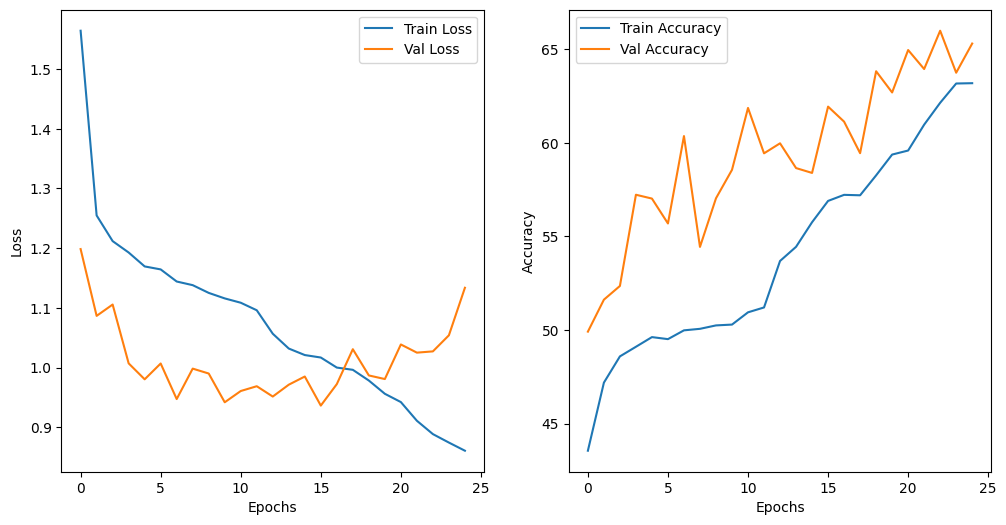

In [113]:
cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = train_model(cnn_model, train_loader, val_loader, epochs=25, lr=0.001)

plot_results(cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies)

In [114]:
def predict_eeg(model, file_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    data = torch.load(file_path, weights_only=False)
    samples = data['samples']
    
    # Apply filtering, feature extraction, and normalization
    samples = bandpass_filter(samples)
    samples = fourier_transform(samples)
    samples = normalize_data(samples)
    
    # Convert to DataLoader for inference
    dataset = EEGDataset(samples, labels=data['labels'])
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    predictions = []
    model.eval()
    with torch.no_grad():
        for sample, _ in loader:
            sample = sample.to(device).float()
            sample = sample.permute(0, 2, 1)
            output = model(sample.float())
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    
    return predictions

# Visualization of predictions
def plot_prediction_time_series(predictions, true_labels, sample_rate=1000, figsize=(100, 10)):
    time = np.arange(0, len(predictions) * 3, 3)  # 3-second intervals
    plt.figure(figsize=figsize)  # Set the figure size
    plt.plot(time, predictions, label='Predicted Sleep Stage')
    plt.plot(time, true_labels, label='True Sleep Stage', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Sleep Stage')
    plt.legend()
    plt.show()

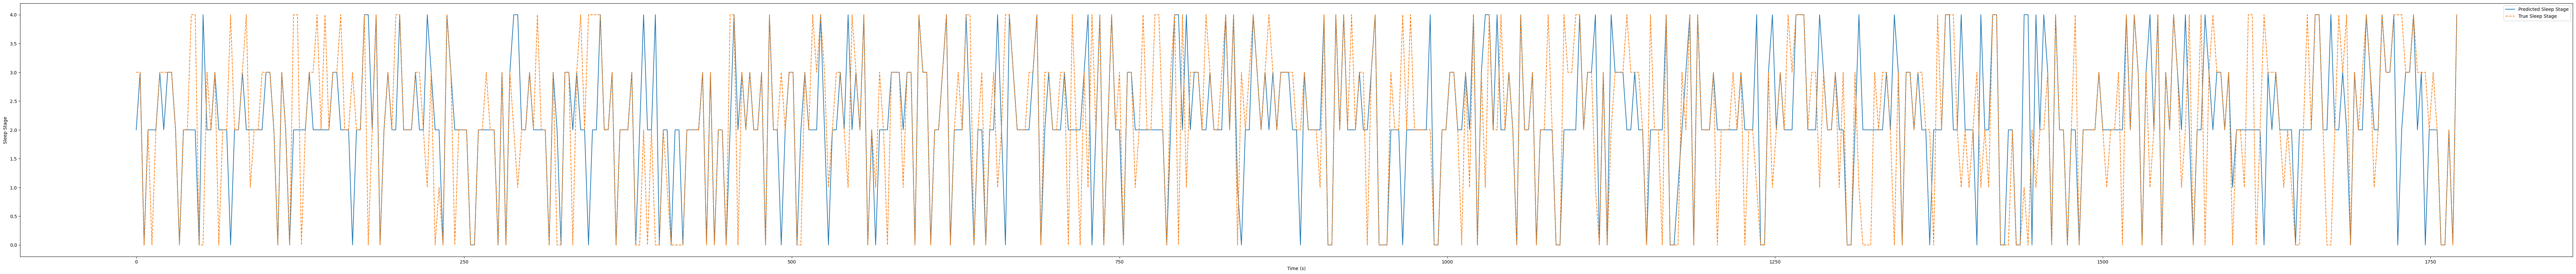

In [115]:
file_path = r'EEG\test_0.pt'
predictions = predict_eeg(cnn_model, file_path)
data = torch.load(file_path, weights_only=False)
true_labels = data['labels']
plot_prediction_time_series(predictions, true_labels)

Using device: cuda


Epoch 1/25: 100%|██████████| 926/926 [00:03<00:00, 288.03it/s]


Epoch [1/25], Train Loss: 1.1550, Train Accuracy: 51.35%, Val Loss: 1.1248, Val Accuracy: 53.24%


Epoch 2/25: 100%|██████████| 926/926 [00:03<00:00, 297.60it/s]


Epoch [2/25], Train Loss: 1.0700, Train Accuracy: 55.11%, Val Loss: 1.1415, Val Accuracy: 50.99%


Epoch 3/25: 100%|██████████| 926/926 [00:03<00:00, 290.12it/s]


Epoch [3/25], Train Loss: 1.0055, Train Accuracy: 58.20%, Val Loss: 1.1444, Val Accuracy: 52.24%


Epoch 4/25: 100%|██████████| 926/926 [00:03<00:00, 273.53it/s]


Epoch [4/25], Train Loss: 0.9312, Train Accuracy: 62.27%, Val Loss: 1.1698, Val Accuracy: 51.35%


Epoch 5/25: 100%|██████████| 926/926 [00:03<00:00, 260.02it/s]


Epoch [5/25], Train Loss: 0.8608, Train Accuracy: 65.40%, Val Loss: 1.2198, Val Accuracy: 49.17%


Epoch 6/25: 100%|██████████| 926/926 [00:03<00:00, 250.74it/s]


Epoch [6/25], Train Loss: 0.7931, Train Accuracy: 68.57%, Val Loss: 1.2497, Val Accuracy: 49.47%


Epoch 7/25: 100%|██████████| 926/926 [00:03<00:00, 241.96it/s]


Epoch [7/25], Train Loss: 0.7259, Train Accuracy: 71.67%, Val Loss: 1.2763, Val Accuracy: 49.65%


Epoch 8/25: 100%|██████████| 926/926 [00:03<00:00, 262.76it/s]


Epoch [8/25], Train Loss: 0.6637, Train Accuracy: 74.46%, Val Loss: 1.3373, Val Accuracy: 49.90%


Epoch 9/25: 100%|██████████| 926/926 [00:03<00:00, 263.06it/s]


Epoch [9/25], Train Loss: 0.6083, Train Accuracy: 76.77%, Val Loss: 1.3923, Val Accuracy: 48.71%


Epoch 10/25: 100%|██████████| 926/926 [00:03<00:00, 276.73it/s]


Epoch [10/25], Train Loss: 0.5635, Train Accuracy: 78.87%, Val Loss: 1.4581, Val Accuracy: 48.05%


Epoch 11/25: 100%|██████████| 926/926 [00:03<00:00, 270.00it/s]


Epoch [11/25], Train Loss: 0.5145, Train Accuracy: 80.96%, Val Loss: 1.5012, Val Accuracy: 48.21%


Epoch 12/25: 100%|██████████| 926/926 [00:03<00:00, 273.46it/s]


Epoch [12/25], Train Loss: 0.4880, Train Accuracy: 81.84%, Val Loss: 1.5565, Val Accuracy: 47.66%


Epoch 13/25: 100%|██████████| 926/926 [00:03<00:00, 272.81it/s]


Epoch [13/25], Train Loss: 0.4623, Train Accuracy: 82.75%, Val Loss: 1.5978, Val Accuracy: 47.86%


Epoch 14/25: 100%|██████████| 926/926 [00:03<00:00, 262.70it/s]


Epoch [14/25], Train Loss: 0.4162, Train Accuracy: 84.64%, Val Loss: 1.6825, Val Accuracy: 48.16%


Epoch 15/25: 100%|██████████| 926/926 [00:03<00:00, 278.06it/s]


Epoch [15/25], Train Loss: 0.3879, Train Accuracy: 85.93%, Val Loss: 1.7062, Val Accuracy: 47.74%


Epoch 16/25: 100%|██████████| 926/926 [00:03<00:00, 265.53it/s]


Epoch [16/25], Train Loss: 0.3781, Train Accuracy: 86.03%, Val Loss: 1.7628, Val Accuracy: 46.94%


Epoch 17/25: 100%|██████████| 926/926 [00:03<00:00, 256.77it/s]


Epoch [17/25], Train Loss: 0.3586, Train Accuracy: 86.82%, Val Loss: 1.8526, Val Accuracy: 46.69%


Epoch 18/25: 100%|██████████| 926/926 [00:03<00:00, 263.11it/s]


Epoch [18/25], Train Loss: 0.3396, Train Accuracy: 87.68%, Val Loss: 1.8563, Val Accuracy: 46.02%


Epoch 19/25: 100%|██████████| 926/926 [00:03<00:00, 263.18it/s]


Epoch [19/25], Train Loss: 0.3143, Train Accuracy: 88.80%, Val Loss: 1.9241, Val Accuracy: 47.04%


Epoch 20/25: 100%|██████████| 926/926 [00:03<00:00, 253.04it/s]


Epoch [20/25], Train Loss: 0.2940, Train Accuracy: 89.54%, Val Loss: 1.9791, Val Accuracy: 46.16%


Epoch 21/25: 100%|██████████| 926/926 [00:03<00:00, 258.89it/s]


Epoch [21/25], Train Loss: 0.2734, Train Accuracy: 90.48%, Val Loss: 2.0526, Val Accuracy: 46.39%


Epoch 22/25: 100%|██████████| 926/926 [00:03<00:00, 261.07it/s]


Epoch [22/25], Train Loss: 0.2631, Train Accuracy: 90.93%, Val Loss: 2.0945, Val Accuracy: 46.33%


Epoch 23/25: 100%|██████████| 926/926 [00:03<00:00, 252.11it/s]


Epoch [23/25], Train Loss: 0.2493, Train Accuracy: 91.31%, Val Loss: 2.1332, Val Accuracy: 46.69%


Epoch 24/25: 100%|██████████| 926/926 [00:03<00:00, 254.71it/s]


Epoch [24/25], Train Loss: 0.2496, Train Accuracy: 91.34%, Val Loss: 2.2140, Val Accuracy: 46.56%


Epoch 25/25: 100%|██████████| 926/926 [00:03<00:00, 256.18it/s]


Epoch [25/25], Train Loss: 0.2408, Train Accuracy: 91.56%, Val Loss: 2.2077, Val Accuracy: 45.47%


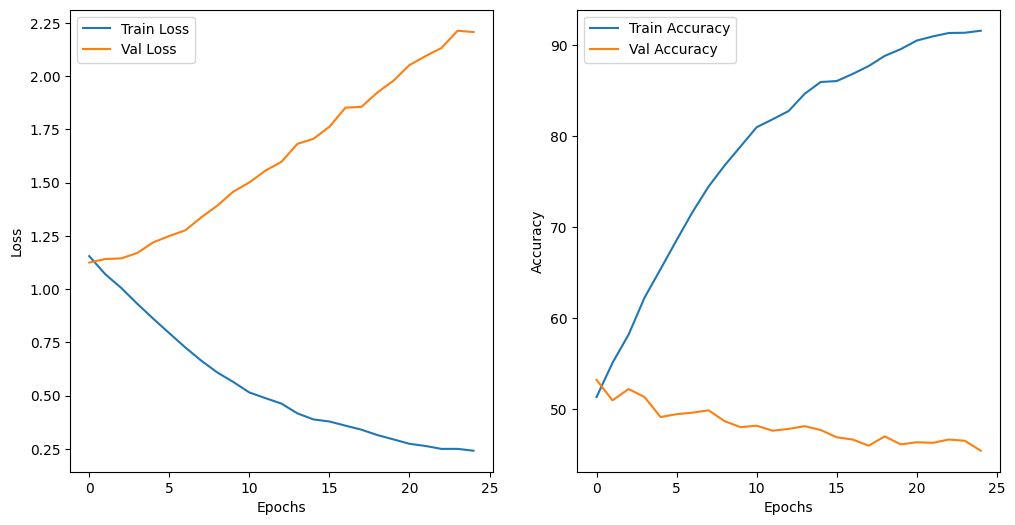

In [116]:
lstm_train_losses, lstm_val_losses, lstm_train_accuracies, lstm_val_accuracies = train_model(lstm_model, train_loader, val_loader, epochs=25, lr=0.001)

plot_results(lstm_train_losses, lstm_val_losses, lstm_train_accuracies, lstm_val_accuracies)

Using device: cuda


Epoch 1/25: 100%|██████████| 926/926 [00:18<00:00, 49.79it/s]


Epoch [1/25], Train Loss: 1.2417, Train Accuracy: 48.60%, Val Loss: 1.1611, Val Accuracy: 51.94%


Epoch 2/25: 100%|██████████| 926/926 [00:18<00:00, 50.58it/s]


Epoch [2/25], Train Loss: 1.1463, Train Accuracy: 53.67%, Val Loss: 1.0683, Val Accuracy: 58.72%


Epoch 3/25: 100%|██████████| 926/926 [00:18<00:00, 50.94it/s]


Epoch [3/25], Train Loss: 1.0646, Train Accuracy: 57.21%, Val Loss: 0.9452, Val Accuracy: 64.23%


Epoch 4/25: 100%|██████████| 926/926 [00:18<00:00, 49.98it/s]


Epoch [4/25], Train Loss: 0.8836, Train Accuracy: 66.42%, Val Loss: 0.7990, Val Accuracy: 69.82%


Epoch 5/25: 100%|██████████| 926/926 [00:17<00:00, 51.55it/s]


Epoch [5/25], Train Loss: 0.8014, Train Accuracy: 70.09%, Val Loss: 0.7410, Val Accuracy: 71.82%


Epoch 6/25: 100%|██████████| 926/926 [00:18<00:00, 50.78it/s]


Epoch [6/25], Train Loss: 0.7284, Train Accuracy: 73.19%, Val Loss: 0.7021, Val Accuracy: 73.98%


Epoch 7/25: 100%|██████████| 926/926 [00:17<00:00, 51.57it/s]


Epoch [7/25], Train Loss: 0.6916, Train Accuracy: 74.79%, Val Loss: 0.6662, Val Accuracy: 75.91%


Epoch 8/25: 100%|██████████| 926/926 [00:17<00:00, 51.44it/s]


Epoch [8/25], Train Loss: 0.6586, Train Accuracy: 76.10%, Val Loss: 0.6324, Val Accuracy: 77.38%


Epoch 9/25: 100%|██████████| 926/926 [00:18<00:00, 50.81it/s]


Epoch [9/25], Train Loss: 0.6122, Train Accuracy: 77.66%, Val Loss: 0.6333, Val Accuracy: 76.62%


Epoch 10/25: 100%|██████████| 926/926 [00:18<00:00, 51.39it/s]


Epoch [10/25], Train Loss: 0.5690, Train Accuracy: 79.21%, Val Loss: 0.5414, Val Accuracy: 80.82%


Epoch 11/25: 100%|██████████| 926/926 [00:18<00:00, 51.11it/s]


Epoch [11/25], Train Loss: 0.5274, Train Accuracy: 80.71%, Val Loss: 0.5299, Val Accuracy: 80.51%


Epoch 12/25: 100%|██████████| 926/926 [00:18<00:00, 48.84it/s]


Epoch [12/25], Train Loss: 0.5053, Train Accuracy: 81.54%, Val Loss: 0.4971, Val Accuracy: 81.94%


Epoch 13/25: 100%|██████████| 926/926 [00:18<00:00, 51.06it/s]


Epoch [13/25], Train Loss: 0.4899, Train Accuracy: 81.95%, Val Loss: 0.5077, Val Accuracy: 81.48%


Epoch 14/25: 100%|██████████| 926/926 [00:18<00:00, 48.98it/s]


Epoch [14/25], Train Loss: 0.4819, Train Accuracy: 82.38%, Val Loss: 0.5709, Val Accuracy: 80.00%


Epoch 15/25: 100%|██████████| 926/926 [00:18<00:00, 51.14it/s]


Epoch [15/25], Train Loss: 0.4695, Train Accuracy: 82.73%, Val Loss: 0.4741, Val Accuracy: 82.41%


Epoch 16/25: 100%|██████████| 926/926 [00:18<00:00, 51.17it/s]


Epoch [16/25], Train Loss: 0.4578, Train Accuracy: 83.15%, Val Loss: 0.4657, Val Accuracy: 82.66%


Epoch 17/25: 100%|██████████| 926/926 [00:18<00:00, 49.17it/s]


Epoch [17/25], Train Loss: 0.4481, Train Accuracy: 83.40%, Val Loss: 0.4506, Val Accuracy: 83.59%


Epoch 18/25: 100%|██████████| 926/926 [00:19<00:00, 48.39it/s]


Epoch [18/25], Train Loss: 0.4401, Train Accuracy: 83.71%, Val Loss: 0.4312, Val Accuracy: 84.32%


Epoch 19/25: 100%|██████████| 926/926 [00:19<00:00, 48.65it/s]


Epoch [19/25], Train Loss: 0.4337, Train Accuracy: 83.97%, Val Loss: 0.4609, Val Accuracy: 83.03%


Epoch 20/25: 100%|██████████| 926/926 [00:18<00:00, 48.85it/s]


Epoch [20/25], Train Loss: 0.4252, Train Accuracy: 84.00%, Val Loss: 0.4481, Val Accuracy: 83.65%


Epoch 21/25: 100%|██████████| 926/926 [00:18<00:00, 48.81it/s]


Epoch [21/25], Train Loss: 0.4207, Train Accuracy: 84.14%, Val Loss: 0.4637, Val Accuracy: 82.50%


Epoch 22/25: 100%|██████████| 926/926 [00:18<00:00, 48.91it/s]


Epoch [22/25], Train Loss: 0.4113, Train Accuracy: 84.78%, Val Loss: 0.4479, Val Accuracy: 83.60%


Epoch 23/25: 100%|██████████| 926/926 [00:18<00:00, 48.83it/s]


Epoch [23/25], Train Loss: 0.4073, Train Accuracy: 84.91%, Val Loss: 0.4348, Val Accuracy: 84.22%


Epoch 24/25: 100%|██████████| 926/926 [00:18<00:00, 48.81it/s]


Epoch [24/25], Train Loss: 0.3996, Train Accuracy: 85.00%, Val Loss: 0.4566, Val Accuracy: 83.32%


Epoch 25/25: 100%|██████████| 926/926 [00:18<00:00, 50.55it/s]


Epoch [25/25], Train Loss: 0.3930, Train Accuracy: 85.27%, Val Loss: 0.4496, Val Accuracy: 83.48%


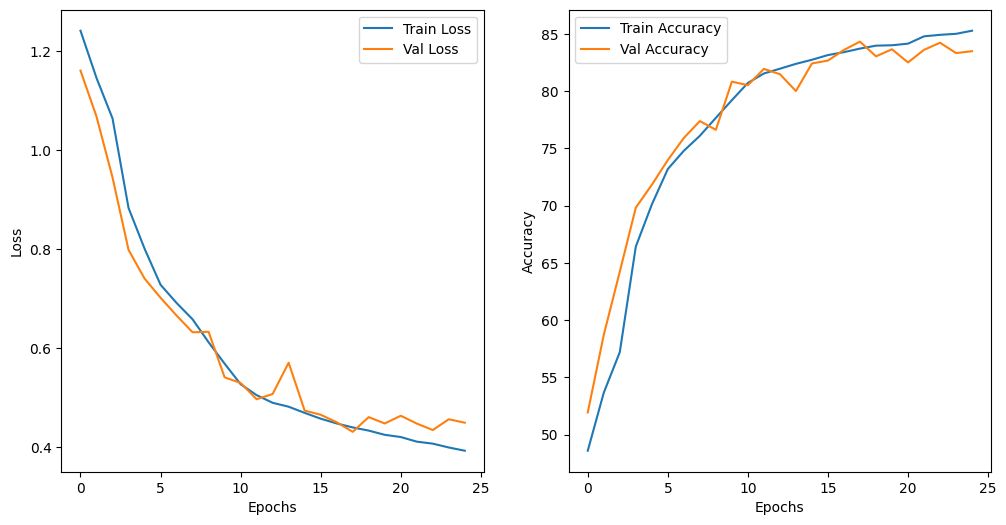

In [117]:
cnn_lstm_train_losses, cnn_lstm_val_losses, cnn_lstm_train_accuracies, cnn_lstm_val_accuracies = train_model(cnn_lstm_model, train_loader, val_loader, epochs=25, lr=0.001)

plot_results(cnn_lstm_train_losses, cnn_lstm_val_losses, cnn_lstm_train_accuracies, cnn_lstm_val_accuracies)

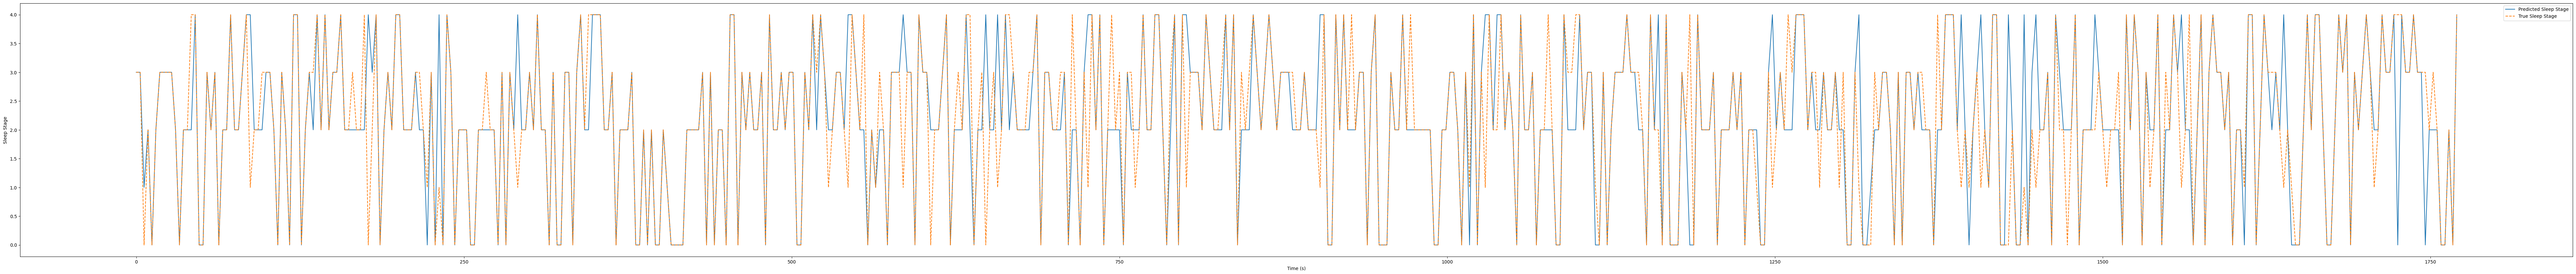

In [118]:
file_path = r'EEG\test_0.pt'
predictions = predict_eeg(cnn_lstm_model, file_path)
data = torch.load(file_path, weights_only=False)
true_labels = data['labels']
plot_prediction_time_series(predictions, true_labels)

In [119]:
torch.save(cnn_model.state_dict(), "cnn_model_weights.pth")
torch.save(lstm_model.state_dict(), "lstm_model_weights.pth")
torch.save(cnn_lstm_model.state_dict(), "cnn_lstm_model_weights.pth")